In [1]:
# import osmnx as ox
import pandas as pd
import geopandas as gpd
import json
from io import StringIO
import warnings
import sys
import os
warnings.filterwarnings("ignore")
sys.stderr = open(os.devnull, 'w')


In [2]:
region = gpd.read_file('9 регионов/Волгоградская область/Каркас населения/region.geojson')
region

,osm_id,name,layer,2019,2020,2021,2022,2023,admin_level,key,admin_center,status,geometry
0,-77665.0,Волгоградская область,Волгоградская область,2507509.0,2491036.0,2474556.0,2449781.0,2470057.0,4,18000000000,,область,"MULTIPOLYGON (((41.16810 50.77451, 41.17850 50..."


In [3]:
district = gpd.read_file('9 регионов/Волгоградская область/Каркас населения/district.geojson')
district

,osm_id,name,layer,2019,2020,2021,2022,2023,admin_level,key,admin_center,status,geometry
0,-1104547.0,Алексеевский район,Алексеевский район,15639.0,15376.0,15209.0,14906.0,14873.0,6,18202000000,ст-ца Алексеевская,муниципальный район,"MULTIPOLYGON (((41.65314 49.95420, 41.72213 49..."
1,-1107968.0,Быковский район,Быковский район,25174.0,24818.0,24573.0,24168.0,24781.0,6,18204000000,рп Быково,муниципальный район,"MULTIPOLYGON (((44.93339 49.11118, 44.96386 49..."
2,-1107378.0,Городищенский район,Городищенский район,61246.0,61993.0,62440.0,62948.0,59337.0,6,18205000000,рп Городище,муниципальный район,"MULTIPOLYGON (((43.76752 48.90334, 43.78124 48..."
3,-1106196.0,Даниловский район,Даниловский район,14000.0,13661.0,13373.0,12802.0,12515.0,6,18206000000,рп Даниловка,муниципальный район,"MULTIPOLYGON (((43.65091 50.41559, 43.65152 50..."
4,-1107379.0,Дубовский район,Дубовский район,28685.0,28382.0,27975.0,27181.0,28817.0,6,18208000000,г Дубовка,муниципальный район,"MULTIPOLYGON (((44.33322 49.35410, 44.33434 49..."
5,-1084791.0,Еланский район,Еланский район,29595.0,29102.0,28673.0,28033.0,28360.0,6,18210000000,рп Елань,муниципальный район,"MULTIPOLYGON (((43.31636 50.90821, 43.33445 50..."
6,-1085908.0,Жирновский район,Жирновский район,38350.0,37927.0,37334.0,36640.0,36278.0,6,18212000000,г Жирновск,муниципальный район,"MULTIPOLYGON (((44.20805 51.15002, 44.20952 51..."
7,-1106840.0,Иловлинский район,Иловлинский район,32950.0,32313.0,31666.0,30846.0,31190.0,6,18214000000,рп Иловля,муниципальный район,"MULTIPOLYGON (((43.38722 49.29424, 43.39505 49..."
8,-1106825.0,Калачевский район,Калачевский район,52382.0,51582.0,51144.0,50259.0,51061.0,6,18216000000,г Калач-на-Дону,муниципальный район,"MULTIPOLYGON (((43.20543 48.35183, 43.20610 48..."
9,-1086558.0,Камышинский район,Камышинский район,40322.0,39644.0,39440.0,38827.0,41135.0,6,18218000000,г Камышин,муниципальный район,"MULTIPOLYGON (((44.78550 50.08318, 44.78736 50..."


In [4]:
settlement = gpd.read_file('9 регионов/Волгоградская область/Каркас населения/settlement.geojson')
settlement

,osm_id,name,layer,2019,2020,2021,2022,2023,admin_level,key,admin_center,status,geometry
0,NaN,Революционное,Палласовский район,1238.0,1218.0,1215.0,1206.0,1056.0,8,None,None,сельское поселение,"MULTIPOLYGON (((46.78903 49.63836, 46.73639 49..."
1,-1446299.0,Стеженское,Алексеевский район,685.0,675.0,694.0,675.0,630.0,8,None,None,сельское поселение,"MULTIPOLYGON (((41.97687 50.29195, 41.97739 50..."
2,-1443108.0,Краснооктябрьское,Алексеевский район,769.0,748.0,725.0,668.0,929.0,8,None,None,сельское поселение,"MULTIPOLYGON (((42.36857 50.28091, 42.36860 50..."
3,-1443107.0,Ларинское,Алексеевский район,714.0,713.0,700.0,694.0,663.0,8,None,None,сельское поселение,"MULTIPOLYGON (((42.21293 50.28499, 42.21300 50..."
4,-1443106.0,Яминское,Алексеевский район,1417.0,1399.0,1384.0,1376.0,1393.0,8,None,None,сельское поселение,"MULTIPOLYGON (((42.19721 50.32547, 42.20512 50..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,-1676128.0,Красноярское,Чернышковский район,1124.0,1110.0,1105.0,1105.0,984.0,8,None,None,сельское поселение,"MULTIPOLYGON (((42.27296 48.40632, 42.27870 48..."
430,-1676127.0,Большетерновское,Чернышковский район,795.0,777.0,745.0,722.0,750.0,8,None,None,сельское поселение,"MULTIPOLYGON (((42.29665 48.45521, 42.32227 48..."
431,-1676000.0,Пристеновское,Чернышковский район,467.0,455.0,442.0,435.0,497.0,8,None,None,сельское поселение,"MULTIPOLYGON (((42.72587 48.28015, 42.72692 48..."
432,-1675999.0,Алешкинское,Чернышковский район,380.0,375.0,364.0,349.0,370.0,8,None,None,сельское поселение,"MULTIPOLYGON (((42.48190 48.22617, 42.49394 48..."


In [5]:
# import osmnx as ox
# import geopandas as gpd
# from shapely.geometry import Polygon, MultiPolygon
# import matplotlib.pyplot as plt

# # Пример загрузки полигона региона
# gdf_region = district.iloc[:10]

# # Преобразование в метрическую проекцию (например, UTM)
# gdf_region_utm = gdf_region.to_crs(epsg=32633)  # Замените epsg на соответствующий вашей области UTM-зоны

# # Проверка CRS
# print(gdf_region_utm.crs)

# # Вычисление площади в квадратных метрах и преобразование в квадратные километры
# gdf_region_utm['area_km2'] = gdf_region_utm.geometry.area / 1e6  # 1 км² = 1,000,000 м²

# # Суммарная площадь региона в квадратных километрах
# region_area_km2 = gdf_region_utm['area_km2'].sum()
# print(f"Region area in square kilometers: {region_area_km2}")


In [6]:
# import osmnx as ox
# import geopandas as gpd
# from shapely.geometry import Polygon, MultiPolygon
# import matplotlib.pyplot as plt
# from retrying import retry

# @retry(stop_max_attempt_number=5, wait_fixed=2000)
# def fetch_osm_data(polygon, tags):
#     return ox.geometries_from_polygon(polygon, tags=tags)

# def get_landuse_data(polygon):
#     print(f"Polygon bounds: {polygon.bounds}")
    
#     # Загрузка данных по различным типам использования земли
#     landuse_tags = {
#         'residential': ['residential'],
#         'commercial': ['commercial'],
#         'industrial': ['industrial'],
#         'forest': ['forest'],
#         'farmland': ['farmland', 'farmyard', 'orchard', 'vineyard', 'greenhouse_horticulture'],
#         'military': ['military'],
#         'protected_area': ['national_park', 'protected_area', 'nature_reserve'],
#         'water': ['basin', 'reservoir', 'water'],
#         'special_use': ['railway', 'cemetery']
#     }
#     landuse_gdfs = {}

#     for category, tags in landuse_tags.items():
#         print(f"Fetching data for category: {category}")
#         tag_filters = [{'landuse': tag} for tag in tags] + [{'natural': tag} for tag in tags if tag in ['wood', 'water']]
#         category_gdf = gpd.GeoDataFrame(columns=['geometry'], geometry='geometry')
        
#         for tag_filter in tag_filters:
#             try:
#                 gdf = fetch_osm_data(polygon, tag_filter)
#                 if not gdf.empty:
#                     gdf = gdf.set_geometry('geometry')
#                     if gdf.crs is None:
#                         gdf.set_crs(epsg=4326, inplace=True)  # Установить исходный CRS как WGS84 (EPSG:4326)
#                     category_gdf = category_gdf.append(gdf, ignore_index=True)
#             except Exception as e:
#                 print(f"Error fetching data for tag filter {tag_filter}: {e}")
        
#         landuse_gdfs[category] = category_gdf
#         print(f"Number of geometries fetched for {category}: {len(landuse_gdfs[category])}")
    
#     return landuse_gdfs



In [7]:
# def calculate_urbanization(region_gdf, landuse_gdfs_list):
#     if region_gdf.crs is None:
#         region_gdf.set_crs(epsg=4326, inplace=True)
    
#     # Преобразование региона в UTM
#     region_gdf_utm = region_gdf.to_crs(epsg=32633)  # Замените epsg на соответствующий вашей области UTM-зоны
#     region_area_km2 = region_gdf_utm.geometry.area.sum() / 1e6  # Площадь региона в квадратных километрах
    
#     print(f"Region area in square kilometers: {region_area_km2}")
    
#     total_landuse_areas_km2 = {key: 0 for key in landuse_gdfs_list[0].keys()}

#     for landuse_gdfs in landuse_gdfs_list:
#         for key, gdf in landuse_gdfs.items():
#             if gdf.crs is None:
#                 gdf.set_crs(epsg=4326, inplace=True)
#             gdf_utm = gdf.to_crs(epsg=32633)  # Преобразование каждого типа земельного использования в UTM
            
#             # Пересечение с регионом
#             gdf_utm_intersect = gpd.overlay(gdf_utm, region_gdf_utm, how='intersection')
#             landuse_area_km2 = gdf_utm_intersect.geometry.area.sum() / 1e6  # Площадь в квадратных километрах
#             total_landuse_areas_km2[key] += landuse_area_km2
#             print(f"Area for {key} in square kilometers (within region): {landuse_area_km2}")

#     urbanization_data = {key: (area / region_area_km2) * 100 for key, area in total_landuse_areas_km2.items()}
    
#     return urbanization_data

In [8]:
# def calculate_urbanization(region_gdf, landuse_gdfs):
#     if region_gdf.crs is None:
#         region_gdf.set_crs(epsg=4326, inplace=True)
    
#     # Преобразование региона в UTM
#     region_gdf_utm = region_gdf.to_crs(epsg=32633)  # Замените epsg на соответствующий вашей области UTM-зоны
#     region_area_km2 = region_gdf_utm.geometry.area.sum() / 1e6  # Площадь региона в квадратных километрах
    
#     print(f"Region area in square kilometers: {region_area_km2}")
    
#     total_landuse_areas_km2 = {key: 0 for key in landuse_gdfs.keys()}

#     for key, gdf in landuse_gdfs.items():
#         if gdf.crs is None:
#             gdf.set_crs(epsg=4326, inplace=True)
#         gdf_utm = gdf.to_crs(epsg=32633)  # Преобразование каждого типа земельного использования в UTM
        
#         # Пересечение с регионом
#         gdf_utm_intersect = gpd.overlay(gdf_utm, region_gdf_utm, how='intersection')
#         landuse_area_km2 = gdf_utm_intersect.geometry.area.sum() / 1e6  # Площадь в квадратных километрах
#         total_landuse_areas_km2[key] += landuse_area_km2
#         print(f"Area for {key} in square kilometers (within region): {landuse_area_km2}")

#     urbanization_data = {key: (area / region_area_km2) * 100 for key, area in total_landuse_areas_km2.items()}
    
#     return urbanization_data

In [9]:
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt
from retrying import retry
from matplotlib.lines import Line2D


# Пример загрузки полигона региона
gdf_region = district.iloc[:2]

# Преобразование в метрическую проекцию (например, UTM)
gdf_region_utm = gdf_region.to_crs(epsg=32633)  # Замените epsg на соответствующий вашей области UTM-зоны

# Проверка CRS
print(gdf_region_utm.crs)

# Вычисление площади в квадратных метрах и преобразование в квадратные километры
gdf_region_utm['area_km2'] = gdf_region_utm.geometry.area / 1e6  # 1 км² = 1,000,000 м²

# Суммарная площадь региона в квадратных километрах
region_area_km2 = gdf_region_utm['area_km2'].sum()
print(f"Region area in square kilometers: {region_area_km2}")

@retry(stop_max_attempt_number=5, wait_fixed=2000)
def fetch_osm_data(polygon, tags):
    return ox.geometries_from_polygon(polygon, tags=tags)

def get_landuse_data(polygon):
    print(f"Polygon bounds: {polygon.bounds}")
    
    # Определение тегов для каждого показателя
    landuse_tags = {
        'residential': ['residential', 'apartments', 'detached'],
        'agricultural_land': ['farmland', 'farmyard', 'orchard', 'vineyard', 'greenhouse_horticulture'],
        'industrial_land': ['industrial'],
        'forest_land': ['forest'],
        'special_use_land': ['military', 'railway', 'cemetery'],
        'urban_land': ['residential', 'commercial', 'industrial', 'recreation_ground', 'cemetery'],
        'protected_nature': ['national_park', 'protected_area', 'nature_reserve'],
        'water_fund_land': ['basin', 'reservoir', 'water'],
    }

    # Собираем все уникальные теги
    unique_tags = set(tag for tags in landuse_tags.values() for tag in tags)
    tag_filters = [{'landuse': tag} for tag in unique_tags] + [{'natural': tag} for tag in unique_tags if tag in ['wood', 'water']]
    
    # Параллельная загрузка данных по уникальным тегам
    unique_gdfs = {}
    with ThreadPoolExecutor() as executor:
        future_to_tag_filter = {executor.submit(fetch_osm_data, polygon, tag_filter): tag_filter for tag_filter in tag_filters}
        for future in as_completed(future_to_tag_filter):
            tag_filter = future_to_tag_filter[future]
            try:
                gdf = future.result()
                if not gdf.empty:
                    gdf = gdf.set_geometry('geometry')
                    if gdf.crs is None:
                        gdf.set_crs(epsg=4326, inplace=True)  # Установить исходный CRS как WGS84 (EPSG:4326)
                    unique_gdfs[frozenset(tag_filter.items())] = gdf
            except Exception as e:
                print(f"Error fetching data for tag filter {tag_filter}: {e}")

    # Распределение данных по категориям
    landuse_gdfs = {}
    for category, tags in landuse_tags.items():
        category_gdf = gpd.GeoDataFrame(columns=['geometry'], geometry='geometry')
        for tag in tags:
            tag_filter = {'landuse': tag} if tag not in ['wood', 'water'] else {'natural': tag}
            gdf = unique_gdfs.get(frozenset(tag_filter.items()))
            if gdf is not None:
                category_gdf = category_gdf.append(gdf, ignore_index=True)
        landuse_gdfs[category] = category_gdf
        print(f"Number of geometries fetched for {category}: {len(landuse_gdfs[category])}")
    
    return landuse_gdfs

def calculate_urbanization(region_gdf, landuse_gdfs_list):
    if region_gdf.crs is None:
        region_gdf.set_crs(epsg=4326, inplace=True)
    
    # Преобразование региона в UTM
    region_gdf_utm = region_gdf.to_crs(epsg=32633)  # Замените epsg на соответствующий вашей области UTM-зоны
    region_area_km2 = region_gdf_utm.geometry.area.sum() / 1e6  # Площадь региона в квадратных километрах
    
    # print(f"Region area in square kilometers: {round(region_area_km2, 1)}")
    
    total_landuse_areas_km2 = {key: 0 for key in landuse_gdfs_list[0].keys()}

    for landuse_gdfs in landuse_gdfs_list:
        for key, gdf in landuse_gdfs.items():
            if gdf.crs is None:
                gdf.set_crs(epsg=4326, inplace=True)
            gdf_utm = gdf.to_crs(epsg=32633)  # Преобразование каждого типа земельного использования в UTM
            
            # Разделение на типы геометрий
            for geom_type in [Polygon, MultiPolygon, Point, LineString]:
                gdf_geom_type = gdf_utm[gdf_utm.geometry.type == geom_type.__name__]
                if not gdf_geom_type.empty:
                    # Пересечение с регионом
                    gdf_utm_intersect = gpd.overlay(gdf_geom_type, region_gdf_utm, how='intersection')
                    landuse_area_km2 = gdf_utm_intersect.geometry.area.sum() / 1e6  # Площадь в квадратных километрах
                    total_landuse_areas_km2[key] += landuse_area_km2
                    # print(f"Area for {key} ({geom_type.__name__}) in square kilometers (within region): {round(landuse_area_km2, 1)}")

    urbanization_data = {key: round((area / region_area_km2) * 100, 1) for key, area in total_landuse_areas_km2.items()}
    
    return urbanization_data



def plot_landuse(region_gdf, landuse_gdfs):
    if region_gdf.crs is None:
        region_gdf.set_crs(epsg=4326, inplace=True)
    region_gdf_utm = region_gdf.to_crs(epsg=32633)  # Преобразование региона в UTM

    fig, ax = plt.subplots(figsize=(10, 10))
    region_gdf_utm.boundary.plot(ax=ax, linewidth=1, color='black', label='Region Boundary')

    colors = {
        'residential_building': 'blue',
        'individual_house': 'cyan',
        'apartment_building': 'navy',
        'agricultural_land': 'yellow',
        'industrial_land': 'gray',
        'forest_land': 'green',
        'special_use_land': 'brown',
        'urban_land': 'orange',
        'protected_nature': 'purple',
        'water_fund_land': 'cyan'
    }
    
    for key, gdf in landuse_gdfs.items():
        if not gdf.empty:
            if gdf.crs is None:
                gdf.set_crs(epsg=4326, inplace=True)
            gdf_utm = gdf.to_crs(epsg=32633)  # Преобразование каждого типа земельного использования в UTM
            gdf_utm.plot(ax=ax, color=colors.get(key, 'gray'), alpha=0.5, label=key)
    
    # Создание пользовательских меток для легенды
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=key,
                              markerfacecolor=color, markersize=10) 
                       for key, color in colors.items()]
    
    ax.legend(handles=legend_elements, loc='upper right')
    plt.show()



EPSG:32633
Region area in square kilometers: 6385.018629807244


In [10]:
gdf_region

,osm_id,name,layer,2019,2020,2021,2022,2023,admin_level,key,admin_center,status,geometry
0,-1104547.0,Алексеевский район,Алексеевский район,15639.0,15376.0,15209.0,14906.0,14873.0,6,18202000000,ст-ца Алексеевская,муниципальный район,"MULTIPOLYGON (((41.65314 49.95420, 41.72213 49..."
1,-1107968.0,Быковский район,Быковский район,25174.0,24818.0,24573.0,24168.0,24781.0,6,18204000000,рп Быково,муниципальный район,"MULTIPOLYGON (((44.93339 49.11118, 44.96386 49..."


In [11]:
landuse_gdfs_list = []

for idx, district in gdf_region.iterrows():
    polygon = district.geometry
    landuse_gdfs = get_landuse_data(polygon)
    landuse_gdfs_list.append(landuse_gdfs)


Polygon bounds: (41.6531365, 49.9123016, 42.7389856, 50.5334541)
Error fetching data for tag filter {'landuse': 'basin'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'military'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'vineyard'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'detached'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'apartments'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'national_park'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'water'}: No data elements in server response. Check log and query location/tags.
Error fetc

In [17]:
# Расчет степени урбанизации для всего региона
urbanization_data = calculate_urbanization(gdf_region, landuse_gdfs_list)

urbanization_data


{'residential': 1.2,
 'agricultural_land': 46.4,
 'industrial_land': 0.0,
 'forest_land': 0.4,
 'special_use_land': 0.0,
 'urban_land': 1.3,
 'protected_nature': 0.0,
 'water_fund_land': 6.7}

In [13]:
urbanization_data

{'residential': 1.2,
 'agricultural_land': 46.4,
 'industrial_land': 0.0,
 'forest_land': 0.4,
 'special_use_land': 0.0,
 'urban_land': 1.3,
 'protected_nature': 0.0,
 'water_fund_land': 6.7}

In [14]:
total_percentage = sum(urbanization_data.values())
print(f"Total percentage: {total_percentage}")

Total percentage: 56.0


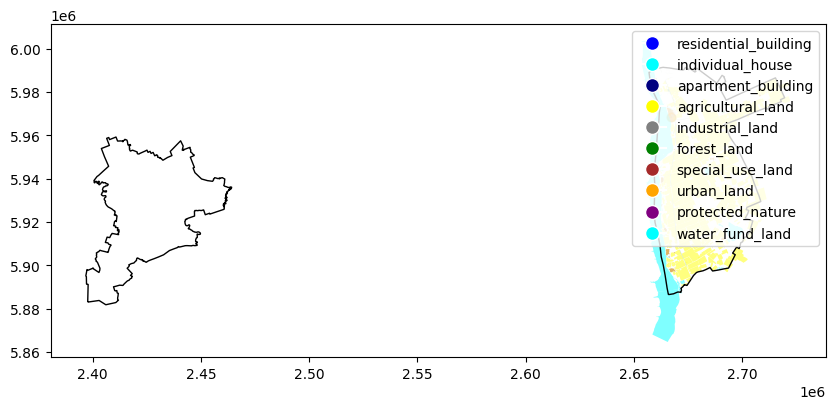

In [15]:
plot_landuse(gdf_region, landuse_gdfs)

In [16]:
# import matplotlib.pyplot as plt
# from matplotlib.lines import Line2D

# def plot_landuse(region_gdf, landuse_gdfs):
#     if region_gdf.crs is None:
#         region_gdf.set_crs(epsg=4326, inplace=True)
#     region_gdf_utm = region_gdf.to_crs(epsg=32633)  # Преобразование региона в UTM

#     fig, ax = plt.subplots(figsize=(10, 10))
#     region_gdf_utm.boundary.plot(ax=ax, linewidth=1, color='black', label='Region Boundary')

#     colors = {
#         'residential': 'blue',
#         'commercial': 'red',
#         'industrial': 'gray',
#         'forest': 'green',
#         'farmland': 'yellow',
#         'military': 'purple',
#         'protected_area': 'orange',
#         'water': 'cyan',
#         'special_use': 'brown'
#     }
    
#     for key, gdf in landuse_gdfs.items():
#         if not gdf.empty:
#             if gdf.crs is None:
#                 gdf.set_crs(epsg=4326, inplace=True)
#             gdf_utm = gdf.to_crs(epsg=32633)  # Преобразование каждого типа земельного использования в UTM
#             gdf_utm.plot(ax=ax, color=colors.get(key, 'gray'), alpha=0.5, label=key)
    
#     # Создание пользовательских меток для легенды
#     legend_elements = [Line2D([0], [0], marker='o', color='w', label=key,
#                               markerfacecolor=color, markersize=10) 
#                        for key, color in colors.items()]
    
#     ax.legend(handles=legend_elements, loc='upper right')
#     plt.show()

# # Пример вызова функции
# plot_landuse(gdf_region, landuse_gdfs)


